# Automatic Ligand parameterization tutorial using BioExcel Building Blocks (biobb)
***
This tutorial aims to illustrate the process of **ligand parameterization** for a **small molecule**, step by step, using the **BioExcel Building Blocks library (biobb)**. The particular example used is the **Ibuprofen** small compound (3-letter code IBP, Drugbank code [DB01050](https://www.drugbank.ca/drugs/DB01050)), a non-steroidal **anti-inflammatory drug** (NSAID) derived from propionic acid and it is considered the first of the propionics. 

**OpenBabel and ACPype** packages are used to **add hydrogens**, **energetically minimize the structure**, and 
**generate parameters** for the **GROMACS** package. With *Generalized Amber Force Field (GAFF)* forcefield and *AM1-BCC* charges.  
***
**Biobb modules** used:

 - [biobb_io](https://github.com/bioexcel/biobb_io): Tools to fetch data to be consumed by the rest of the Biobb building blocks.
 - [biobb_chemistry](https://github.com/bioexcel/biobb_chemistry): Tools to manipulate chemistry data.
 
**Auxiliar libraries** used:

 - [nb_conda_kernels](https://github.com/Anaconda-Platform/nb_conda_kernels): Enables a Jupyter Notebook or JupyterLab application in one conda environment to access kernels for Python, R, and other languages found in other environments.
 - [nglview](http://nglviewer.org/#nglview): Jupyter/IPython widget to interactively view molecular structures and trajectories in notebooks.
 - [ipywidgets](https://github.com/jupyter-widgets/ipywidgets): Interactive HTML widgets for Jupyter notebooks and the IPython kernel.

### Conda Installation and Launch

```console
git clone https://github.com/bioexcel/biobb_wf_ligand_parameterization.git
cd biobb_wf_ligand_parameterization
conda env create -f conda_env/environment.yml
conda activate biobb_ligand_parameterization_tutorial
jupyter-nbextension enable --py --user widgetsnbextension
jupyter-nbextension enable --py --user nglview
jupyter-notebook biobb_wf_ligand_parameterization/notebooks/biobb_ligand_parameterization_tutorial.ipynb
  ``` 

***
### Pipeline steps:
 1. [Input Parameters](#input)
 2. [Fetching Ligand Structure](#fetch)
 3. [Add Hydrogen Atoms](#addh)
 4. [Energetically Minimize Hydrogen Atoms](#min)
 5. [Generating Ligand Parameters](#acpype)
 6. [Output Files](#output)
 
***
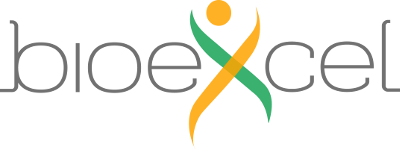
***

<a id="input"></a>
***
## Input parameters
**Input parameters** needed:
 - **ligandCode**: 3-letter code of the ligand structure (e.g. IBP)
 - **mol_charge**: Molecule net charge (e.g. -1)
 - **pH**: Acidity or alkalinity for the small molecule. Hydrogen atoms will be added according to this pH. (e.g. 7.4)

In [40]:
import nglview
import ipywidgets
import os

ligandCode = 'IBP'
mol_charge = 0
pH = 7.4

<a id="fetch"></a>
***
## Fetching ligand structure
Downloading **ligand structure** in **PDB format** from the IRB PDB MIRROR database.<br>
Alternatively, a **PDB file** can be used as starting structure. <br>
***
**Building Blocks** used:

 - [Ligand](https://biobb-io.readthedocs.io/en/latest/api.html#module-api.ligand) from **biobb_io.api.ligand**
***

In [41]:
# Ligand: Download ligand structure from MMB PDB mirror REST API (http://mmb.irbbarcelona.org/api/)
# Import module
from biobb_io.api.ligand import Ligand
from biobb_io.api.pdb import Pdb

# Create prop dict and inputs/outputs
input_structure = ligandCode + '.pdb'

prop = {
    'ligand_code' : ligandCode
}

#Create and launch bb
Ligand(output_pdb_path=input_structure,
        properties=prop).launch()

2019-10-17 16:17:54,781 [MainThread  ] [INFO ]  Downloading: ibp from: http://mmb.irbbarcelona.org/api/pdbMonomer/ibp
2019-10-17 16:17:54,975 [MainThread  ] [INFO ]  Writting pdb to: /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_ligand_parameterization/biobb_wf_ligand_parameterization/notebooks/IBP.pdb


### Visualizing 3D structure
Visualizing the downloaded/given **ligand PDB structure** using **NGL**:    

In [54]:
#Show small ligand structure
view = nglview.show_structure_file(input_structure)
view.add_representation(repr_type='ball+stick', selection='all')
view._remote_call('setSize', target='Widget', args=['','300px'])
view.camera='orthographic'
view

NGLWidget()

In [53]:
view.render_image()
view.download_image(filename='ngl1.png')

<img src='ngl1.png'></img>

<a id="addh"></a>
***
## Add Hydrogen Atoms
Adding **Hydrogen atoms** to the small molecule, according to the given pH.
***
**Building Blocks** used:
 - [BabelAddHydrogens](https://biobb-chemistry.readthedocs.io/en/latest/babelm.html#module-babelm.babel_add_hydrogens) from **biobb_chemistry.babelm.babel_add_hydrogens** 
***

In [43]:
# Babel_add_hydrogens: add Hydrogen atoms to a small molecule
# Import module
from biobb_chemistry.babelm.babel_add_hydrogens import BabelAddHydrogens

# Create prop dict and inputs/outputs
output_babel_h = ligandCode + '.H.mol2' 

prop = {
    'ph' : pH,
    'input_format' : 'pdb',
    'output_format' : 'mol2'
}

#Create and launch bb
BabelAddHydrogens(input_path=input_structure,
                  output_path=output_babel_h,
                  properties=prop).launch()

2019-10-17 16:17:55,057 [MainThread  ] [INFO ]  Value  is not compatible as a coordinates value
2019-10-17 16:17:55,168 [MainThread  ] [INFO ]  obabel -ipdb IBP.pdb -omol2 -OIBP.H.mol2  -h -p 7.4

2019-10-17 16:17:55,169 [MainThread  ] [INFO ]  Exit code 0

2019-10-17 16:17:55,170 [MainThread  ] [INFO ]  1 molecule converted



0

### Visualizing 3D structure
Visualizing the **ligand PDB structure** with the newly added **hydrogen atoms** using **NGL**:    

In [55]:
#Show small ligand structure
view = nglview.show_structure_file(output_babel_h)
view.add_representation(repr_type='ball+stick', selection='all')
view.camera='orthographic'
view

NGLWidget()

In [56]:
view.render_image()
view.download_image(filename='ngl2.png')

<img src='ngl2.png'></img>

<a id="min"></a>
***
## Energetically minimize Hydrogen Atoms
Energetically minimize newly added **Hydrogen atoms**.
***
**Building Blocks** used:
 - [BabelMinimize](https://biobb-chemistry.readthedocs.io/en/latest/babelm.html#module-babelm.babel_minimize) from **biobb_chemistry.babelm.babel_minimize** 
***

In [45]:
# Babel_minimize: Structure energy minimization of a small molecule after being modified adding hydrogen atoms
# Import module
from biobb_chemistry.babelm.babel_minimize import BabelMinimize

# Create prop dict and inputs/outputs
output_babel_min = ligandCode + '.H.min.pdb'                              
prop = {
    'method' : 'sd',
    'criteria' : '1e-10',
    'force_field' : 'GAFF'
}


#Create and launch bb
BabelMinimize(input_path=output_babel_h,
              output_path=output_babel_min,
              properties=prop).launch()

2019-10-17 16:17:55,224 [MainThread  ] [INFO ]  Hydrogens  is not correct, assigned default value: False
2019-10-17 16:17:55,225 [MainThread  ] [INFO ]  Steps  is not correct, assigned default value: 2500
2019-10-17 16:17:55,227 [MainThread  ] [INFO ]  Cut-off  is not correct, assigned default value: False
2019-10-17 16:17:55,233 [MainThread  ] [INFO ]  Rvdw  is not correct, assigned default value: 6.0
2019-10-17 16:17:55,239 [MainThread  ] [INFO ]  Rele  is not correct, assigned default value: 10.0
2019-10-17 16:17:55,240 [MainThread  ] [INFO ]  Frequency  is not correct, assigned default value: 10
2019-10-17 16:17:56,233 [MainThread  ] [INFO ]  obminimize -c 1e-10 -sd -ff GAFF -imol2 IBP.H.mol2 -opdb > IBP.H.min.pdb

2019-10-17 16:17:56,234 [MainThread  ] [INFO ]  Exit code 0

2019-10-17 16:17:56,235 [MainThread  ] [INFO ]  
A T O M   T Y P E S

IDX	TYPE	RING
1	c	NO
2	c3	NO
3	c3	NO
4	c3	NO
5	c3	NO
6	c3	NO
7	c3	NO
8	ca	AR
9	ca	AR
10	ca	AR
11	ca	AR
12	ca	AR
13	ca	AR
14	oh	NO
15	o	NO
16

0

### Visualizing 3D structure
Visualizing the **ligand PDB structure** with the newly added **hydrogen atoms**, **energetically minimized**, using **NGL**:    

In [57]:
#Show small ligand structure
view = nglview.show_structure_file(output_babel_min)
view.add_representation(repr_type='ball+stick', selection='all')
view._remote_call('setSize', target='Widget', args=['','300px'])
view.camera='orthographic'
view

NGLWidget()

In [58]:
view.render_image()
view.download_image(filename='ngl3.png')

<img src='ngl3.png'></img>

### Visualizing 3D structures
Visualizing all the structures generated so far:

 - Original **ligand PDB structure** (left)
 - **Ligand PDB structure** with **hydrogen atoms** (middle)
 - **Ligand PDB structure** with **hydrogen atoms energetically minimized** (right)  

In [61]:
#Show different structures generated (for comparison)
view1 = nglview.show_structure_file(input_structure)
view1.add_representation(repr_type='ball+stick')
view1._remote_call('setSize', target='Widget', args=['250px','300px'])
view1.camera='orthographic'
view1
view2 = nglview.show_structure_file(output_babel_h)
view2.add_representation(repr_type='ball+stick')
view2._remote_call('setSize', target='Widget', args=['250px','300px'])
view2.camera='orthographic'
view2
view3 = nglview.show_structure_file(output_babel_min)
view3.add_representation(repr_type='ball+stick')
view3._remote_call('setSize', target='Widget', args=['250px','300px'])
view3.camera='orthographic'
view3
ipywidgets.HBox([view1, view2, view3])

In [62]:
view1.render_image()
view1.download_image(filename='ngl4.png')
view2.render_image()
view2.download_image(filename='ngl5.png')
view3.render_image()
view3.download_image(filename='ngl6.png')

<img src='ngl4.png' style='float:left;width:33%;'></img><img src='ngl5.png' style='float:left;width:33%;'></img><img src='ngl6.png' style='float:left;width:33%;'></img>

<a id="acpype"></a>
***
## Generating ligand parameters
**Building GROMACS topology** corresponding to the **ligand structure**.

**Force field** used in this tutorial step is **amberGAFF**: [General AMBER Force Field](http://ambermd.org/antechamber/gaff.html), designed for rational drug design.

***
**Building Blocks** used:
- [AcpypeParamsGMX](https://biobb-chemistry.readthedocs.io/en/latest/acpype.html#module-acpype.acpype_params_gmx) from **biobb_chemistry.acpype.acpype_params_gmx** 
***

In [48]:
# Acpype_params_gmx: Generation of topologies for GROMACS with ACPype
# Import module
from biobb_chemistry.acpype.acpype_params_gmx import AcpypeParamsGMX

# Create prop dict and inputs/outputs
output_acpype_gro = ligandCode + 'params.gro'
output_acpype_itp = ligandCode + 'params.itp'
output_acpype_top = ligandCode + 'params.top'
output_acpype = ligandCode + 'params'
prop = {
    'basename' : output_acpype,
    'charge' : mol_charge
}

#Create and launch bb
AcpypeParamsGMX(input_path=output_babel_min,
                output_path_gro=output_acpype_gro,
                output_path_itp=output_acpype_itp,
                output_path_top=output_acpype_top,
                properties=prop).launch()

2019-10-17 16:17:56,425 [MainThread  ] [INFO ]  Running acpype, this execution can take a while
2019-10-17 16:18:17,566 [MainThread  ] [INFO ]  acpype -i /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_ligand_parameterization/biobb_wf_ligand_parameterization/notebooks/IBP.H.min.pdb -b IBPparams.NWZ6JV -n -1

2019-10-17 16:18:17,572 [MainThread  ] [INFO ]  Exit code 0

2019-10-17 16:18:17,577 [MainThread  ] [INFO ]  ========================================================================================
| ACPYPE: AnteChamber PYthon Parser interfacE v. 2018-04-24T22:34:57UTC (c) 2019 AWSdS |
==> ... charge set to -1
==> ... converting pdb input file to mol2 input file
==> * Babel OK *
==> Executing Antechamber...
==> * Antechamber OK *
==> * Parmchk OK *
==> Executing Tleap...
++++++++++start_quote+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Checking 'IBP'....

/anaconda3/envs/biobb_dev/bin/teLeap: Warning!
The unperturbed charge of the unit (-0.998999) is not zero.

0

### Visualizing 3D structure
Visualizing the generated **GROMACS** gro structure corresponding to the parameterized **ligand PDB structure** using **NGL**:    

In [63]:
#Show small ligand structure
view = nglview.show_structure_file(output_acpype_gro)
view.add_representation(repr_type='ball+stick', selection='all')
view._remote_call('setSize', target='Widget', args=['','300px'])
view.camera='orthographic'
view

NGLWidget()

In [64]:
view.render_image()
view.download_image(filename='ngl7.png')

<img src='ngl7.png'></img>

<a id="output"></a>
## Output files

Important **Output files** generated:
 - {{output_acpype_gro}}: **Structure** of the parameterized ligand in gro (GROMACS) format.
 - {{output_acpype_top}}: **Topology** of the parameterized ligand, including a reference to the {{output_acpype_itp}}.
 - {{output_acpype_itp}}: **Include Topology File (itp)** of the parameterized ligand, including the parameters information: bonds, angles, dihedrals, etc.